
## ADS 507 - DATA ENGINEERING
### TEAM 2
##### MARVIN MORAN, MURIS SAAB, RAVITA KARTAWINATA


# DRINK DATABASE PIPELINE
This project is to construct a database schema and pipeline for non-alcohol and alcohol beverages with four datasets with ETL approach that would store a final dataset in Azure/ Test Database which will be used to perform EDA

## Loading Libraries and DB access parameters

In [16]:
import pandas as pd
import mysql.connector
import sqlalchemy
from sqlalchemy import  text, MetaData
import requests
import sqlite3
import json
import seaborn as sns
from matplotlib import pyplot as plt

# parameter in local database/ test
userName = 'Ravi'
userPass = 'password'
host='localhost'
port=3306
database='test'

"""
# parameter in Azure database/ test
userName = 'ravi'
userPass = 'Password507'
host='sakila-2.mysql.database.azure.com'
port=3306
database='test'
"""

"\n# parameter in Azure database/ test\nuserName = 'ravi'\nuserPass = 'Password507'\nhost='sakila-2.mysql.database.azure.com'\nport=3306\ndatabase='test'\n"

## Step 1: Retrieve Data from API (Json Files) and CSV files
API JSON files of Drink and Glass are originated from https://www.thecocktaildb.com/api.php. There two datasets are from API. Another 2 datasets of Category and Ingredient come from CSV files

In [17]:
# CSV datasource - list of category(c), ingredient(i)
df_category_csv = pd.read_csv('C:/Users/rkartawi/Desktop/Ravita/MSADS/507/ADS507/category.csv')
df_ingrident_csv = pd.read_csv('C:/Users/rkartawi/Desktop/Ravita/MSADS/507/ADS507/ingredient.csv')

#Display data
df_category_csv.head()
df_ingrident_csv.head()

,strIngredient1,strCountryofOrigin
0,Light rum,Caribbean
1,Applejack,United States
2,Gin,Netherlands
3,Dark rum,Caribbean
4,Sweet Vermouth,Italy


In [18]:
#API Search cocktails by first letter and load all first characters
all_drinks = []
for letter in 'abcdefghijklmnopqrstvwyz12345679%':
    # Make the API request with the current letter
    response = requests.get(f"https://www.thecocktaildb.com/api/json/v1/1/search.php?f={letter}")
    # Get the JSON data from the response
    data = response.json()
    # Append the 'drinks' data from the response to the list
    all_drinks.extend(data['drinks'])
df = pd.DataFrame(all_drinks)

response_glass = requests.get(f"https://www.thecocktaildb.com/api/json/v1/1/list.php?g=list")
data_glass = response_glass.json()
df_glass = pd.DataFrame(data_glass['drinks'])

# generate json files to C drive
with open('all_drinks.json', 'w') as json_file:
    json.dump(all_drinks, json_file)
with open('data_glass.json', 'w') as json_file:
    json.dump(data_glass, json_file)

## Step 2: Data Cleanup
Check Columns with null values. Drink JSON file has null values on some of the attributes which don't add any value to the data. These columns will be dropped from dataframe before it's loaded to database

In [19]:
# Count the number of null values in each column
null_counts = df.isnull().sum()
null_counts
#columns_to_drop = df.columns[df.isnull().any()]

idDrink                          0
strDrink                         0
strDrinkAlternate              466
strTags                        360
strVideo                       443
strCategory                      0
strIBA                         402
strAlcoholic                     0
strGlass                         0
strInstructions                  0
strInstructionsES              434
strInstructionsDE               45
strInstructionsFR              466
strInstructionsIT               10
strInstructionsZH-HANS         466
strInstructionsZH-HANT         466
strDrinkThumb                    0
strIngredient1                   0
strIngredient2                   0
strIngredient3                  74
strIngredient4                 222
strIngredient5                 318
strIngredient6                 399
strIngredient7                 445
strIngredient8                 460
strIngredient9                 463
strIngredient10                465
strIngredient11                465
strIngredient12     

In [20]:
# Remove unneccessary columns from drink
columns_to_drop = ['strDrinkAlternate', 'strTags', 'strVideo', 'strIBA',
                   'strInstructionsES', 'strInstructionsDE', 'strInstructionsFR', 'strInstructionsIT', 
                   'strInstructionsZH-HANS', 'strInstructionsZH-HANT', 'strDrinkThumb', 
                   'strIngredient4', 'strIngredient5', 'strIngredient6', 'strIngredient7', 'strIngredient8',
                   'strIngredient9', 'strIngredient10', 'strIngredient11', 'strIngredient12', 'strIngredient13', 
                    'strIngredient14', 'strIngredient15', 'strMeasure1', 'strMeasure2', 'strMeasure3', 'strMeasure4',	
                    'strMeasure5', 'strMeasure6', 'strMeasure7', 'strMeasure8', 'strMeasure9', 'strMeasure10',
                    'strMeasure11', 'strMeasure12', 'strMeasure13', 'strMeasure14', 'strMeasure15', 'strImageSource',
                    'strImageAttribution', 'strCreativeCommonsConfirmed'
                    ]
df.drop(columns=[col for col in columns_to_drop if col in df.columns], inplace=True)
 
 # Add column of Adult Drink (y/n)
#df['strAdult_Drink'] = df['strAlcoholic'].apply(lambda x: 'Y' if x == "Alcoholic" else 'N')
#df.info()



## Step 3: SQL

### Step 3a: Connect to AZURE/ TEST Database

In [21]:
# create engine to execute 
engine = sqlalchemy.create_engine(f"mysql+mysqlconnector://{userName}:{userPass}@{host}:{port}/{database}")

### Step 3b: Create Table in TEST Database

In [22]:
# Create Tables Queries
Create_category_table_q =   """
                            CREATE TABLE test.category (
                            strCategory VARCHAR(50) NOT NULL,
                            strDescription VARCHAR(150) NOT NULL,
                            PRIMARY KEY (strCategory)); 
                            """

Create_ingredient_table_q = """
                            CREATE TABLE test.ingredient (
                            strIngredient1 VARCHAR(50) NOT NULL,
                            strCountryofOrigin VARCHAR(150) NOT NULL,
                            PRIMARY KEY (strIngredient1));
                            """

Create_glass_table_q = """
                        CREATE TABLE test.glass (
                        strGlass VARCHAR(50) NOT NULL,
                        PRIMARY KEY (strGlass));
                        """

Create_drink_table_q = """
                        CREATE TABLE test.drink (
                        idDrink INT NOT NULL,
                        strDrink VARCHAR(150),
                        strCategory VARCHAR(50),
                        strAlcoholic VARCHAR(50),
                        strGlass VARCHAR(50),
                        strInstructions VARCHAR(250),
                        strIngredient1 VARCHAR(50),
                        strIngredient2 VARCHAR(50),
                        strIngredient3 VARCHAR(50),
                        dateModified DATETIME,
                        PRIMARY KEY (idDrink));
                        """

In [23]:
# Execute "Create TABLE" queries
with engine.connect() as conn:
  result = conn.execute(text(Create_category_table_q))
  print("Table 'Category' created successfully.")

  result = conn.execute(text(Create_ingredient_table_q))
  print("Table 'Ingredient' created successfully.")

  result = conn.execute(text(Create_glass_table_q))
  print("Table 'Glass' created successfully.")

  result = conn.execute(text(Create_drink_table_q))
  print("Table 'Drink' created successfully.")


Table 'Category' created successfully.
Table 'Ingredient' created successfully.
Table 'Glass' created successfully.
Table 'Drink' created successfully.


### Step 3c: Load transformed data to SQL Tables
Clean-up data from JSON Files and CSV files are stored in mySQL tables

In [24]:
# Load DataFrame from CSV and API Json Files into Azure MySQL table

df_category_csv.to_sql('category', con=engine, if_exists='replace', index=False)
df_ingrident_csv.to_sql('ingredient', con=engine, if_exists='replace', index=False)
df_glass.to_sql('glass', con=engine, if_exists='replace', index=False)
df.to_sql('drink', con=engine, if_exists='replace', index=False)


466

### Step 3d: Add a new column in SQL table
A new column "Adult Drink" is generated from strAlcoholic field. 

In [25]:
# query statement
Alter_drink_q = """
                ALTER TABLE drink
                ADD COLUMN strAdult_Drink VARCHAR(1);
                """
Update_drink_q = """
                UPDATE drink
                SET strAdult_Drink = CASE
                WHEN strAlcoholic = 'Alcoholic' THEN 'Y'
                ELSE 'N'
                END;
                """
"""
with engine.connect() as conn:
  result = conn.execute(text(Alter_drink_q))
  print("Table 'Drink' updated with strAdult_Drink Field successfully.")
  result = conn.execute(text(Update_drink_q))
  print("Table 'Drink' updated with strAdult_Drink values successfully.")
  """

'\nwith engine.connect() as conn:\n  result = conn.execute(text(Alter_drink_q))\n  print("Table \'Drink\' updated with strAdult_Drink Field successfully.")\n  result = conn.execute(text(Update_drink_q))\n  print("Table \'Drink\' updated with strAdult_Drink values successfully.")\n  '

## Step 4: Data Queries and Plots
Perform data queries from drink with relationship to Ingredient

### Step 4a: Data Query by Category

**Catalog Window**

User searched for Ingredient: Vermouth
option: Ingredient
user_input: Vermouth
Search count: 39
SELECT count(*) as count, strCategory
                        FROM drink
                        WHERE strIngredient1 like '%Vermouth%' 
                        or strIngredient2 like '%Vermouth%'
                        or strIngredient3 like '%Vermouth%'
                        GROUP BY strCategory


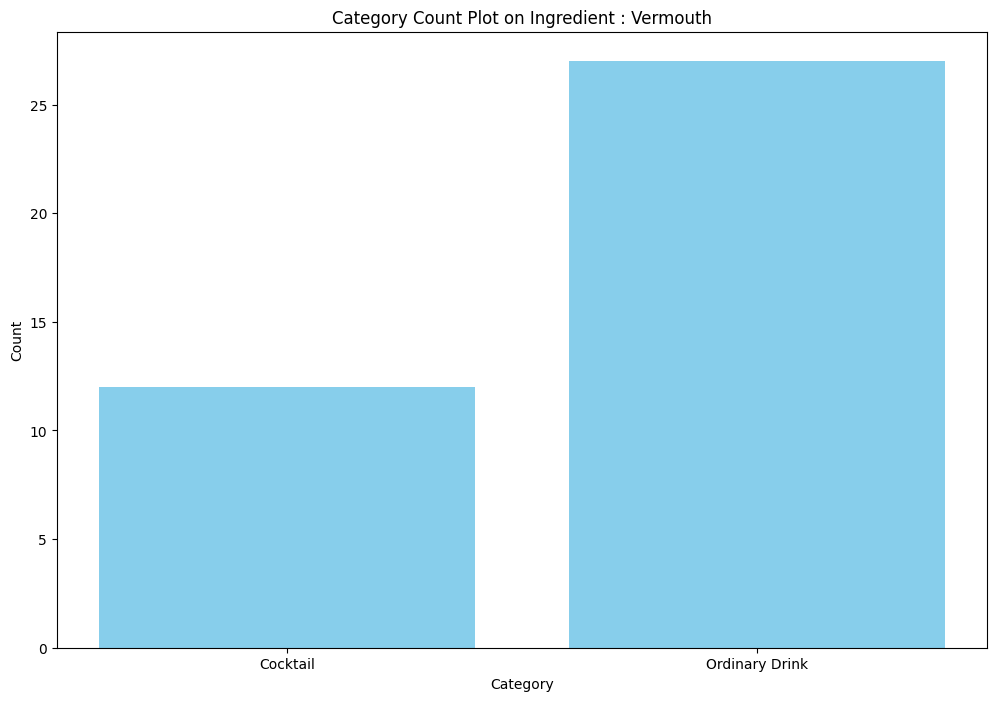

In [26]:
import tkinter as tk
from tkinter import simpledialog
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg

global_user_input = None
global_option = None

def show_popup(option):
    global global_user_input, global_option
    
    # Ask the user for input with a pop-up window
    subtext = "Ingredient eg. gin, vodka, vermouth ...." if option == "Ingredient" else "Glass eg. beer, cocktail, whiskey..."
    user_input = simpledialog.askstring("Input", f"Enter {option}: \n{subtext}")
    
    # Check if the user clicked Cancel or entered a value
    if user_input is not None:
        result_label.config(text=f"User searched for {option}: {user_input}")
        global_user_input = user_input
        global_option = option
        print(f"User searched for {option}: {user_input}")
        root.destroy()

    else:
        result_label.config(text=f"User clicked Cancel for {option}")

# Create the main window
root = tk.Tk()
root.title("Button Selection")

# Create buttons to trigger the pop-up for "Glass Type", "Ingredient""
button_font = ("Arial", 12)  

glass_type_button = tk.Button(root, text="Glass Type", font=button_font, command=lambda: show_popup("Glass"), width=20, height=2)
glass_type_button.grid(row=1, column=0, padx=10)

ingredient_button = tk.Button(root, text="Ingredient", font=button_font, command=lambda: show_popup("Ingredient"), width=20, height=2)
ingredient_button.grid(row=1, column=3, padx=10)

# Create a label to display the result
result_label = tk.Label(root, text=(f"Result for {global_option}: {global_user_input}"))
result_label.grid(row=2, column=0, columnspan=4, pady=10)

# Start the Tkinter event loop
root.mainloop()

# Access global_user_input and global_option outside the Tkinter event loop
if global_user_input is not None and global_option is not None:
    print("option:", global_option)
    print("user_input:", global_user_input)

# STARTING THE QUERY FOR TABLE OR LIST BY INGREDIENT OR GLASS
if global_option == "Ingredient":
    count_query = text(f"""SELECT count(*) FROM drink 
                       WHERE strIngredient1 like '%{global_user_input}%'
                        or strIngredient2 like '%{global_user_input}%'
                        or strIngredient3 like '%{global_user_input}%'""")
    select_query = text(f"""SELECT strDrink, strCategory, strGlass, strAlcoholic, 
                        strIngredient1, strIngredient2, strIngredient3, strInstructions
                        FROM drink 
                        WHERE strIngredient1 like '%{global_user_input}%' 
                        or strIngredient2 like '%{global_user_input}%'
                        or strIngredient3 like '%{global_user_input}%'""")
else:
    count_query = text(f"""SELECT count(*) FROM drink WHERE strglass = '%{global_user_input}%'""")
    select_query = text(f"""SELECT strDrink, strCategory, strGlass, strAlcoholic, 
                        strIngredient1, strIngredient2, strIngredient3, strInstructions
                        FROM drink WHERE strglass = '%{global_user_input}%'""")
#print(select_query)
# Execute the SELECT query
with engine.connect() as conn:
    count = conn.execute(count_query)
    count_result = count.scalar()
    
    result = conn.execute(select_query)
    rows = result.fetchall()

#Display the result
print(f"Search count: {count_result}")
df_query = pd.DataFrame(rows, columns=result.keys())
df_query

# QUERY FOR THE PLOT BY CATEGORY
if global_option == "Ingredient":
    plot_query = text(f"""SELECT count(*) as count, strCategory
                        FROM drink
                        WHERE strIngredient1 like '%{global_user_input}%' 
                        or strIngredient2 like '%{global_user_input}%'
                        or strIngredient3 like '%{global_user_input}%'
                        GROUP BY strCategory""")
else:
    plot_query = text(f"""SELECT count(*) as count, strCategory
                        FROM drink
                        WHERE strGlass like '%{global_user_input}%' 
                        GROUP BY strCategory""")
    
print(plot_query)
with engine.connect() as conn:
    result = conn.execute(plot_query)
    rows = result.fetchall()

#Display the result
df_query = pd.DataFrame(rows, columns=result.keys())
#df_query

# Plotting the bar chart by Category
fig = plt.figure(figsize=(12, 8))
plt.bar(df_query['strCategory'], df_query['count'], color='skyblue')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title(f"Category Count Plot on {global_option} : {global_user_input}")
#plt.show()

# DISPLAY RESULT IN GUI FRAME 
def display_dataframe():
    root = tk.Tk()
    root.title("DataFrame Result")

    tree = ttk.Treeview(root)
    tree["columns"] = list(df_query.columns)
    tree["show"] = "headings"

    for column in df_query.columns:
        tree.heading(column, text=column)

    for index, row in df_query.iterrows():
        tree.insert("", "end", values=list(row))

    tree.pack(expand=True, fill="both")
    # Create a canvas to display the plot
    canvas = FigureCanvasTkAgg(fig, master=root)
    canvas.draw()
    canvas.get_tk_widget().pack()

    root.mainloop()

display_dataframe()

### Step 4b: Join Data Query by Country of Origin

In [27]:
# Query by Ingredient country origin or Category
if global_option == "Ingredient":
        count_query = text(f"""SELECT count(*) FROM drink d
                            JOIN ingredient i ON i.strIngredient1 = d.strIngredient1
                            or i.strIngredient1 = d.strIngredient2
                            or i.strIngredient1 = d.strIngredient3
                            WHERE d.strIngredient1 like '%{global_user_input}%' 
                            or d.strIngredient2 like '%{global_user_input}%'
                            or d.strIngredient3 like '%{global_user_input}%'
                            GROUP BY i.strCountryofOrigin""")
        
        select_query = text(f"""SELECT d.strDrink, d.strCategory, d.strGlass, i.strCountryofOrigin, 
                            d.strIngredient1, d.strIngredient2, d.strIngredient3
                            FROM drink d
                            JOIN ingredient i ON i.strIngredient1 = d.strIngredient1
                            or i.strIngredient1 = d.strIngredient2
                            or i.strIngredient1 = d.strIngredient3
                            WHERE d.strIngredient1 like '%{global_user_input}%' 
                            or d.strIngredient2 like '%{global_user_input}%'
                            or d.strIngredient3 like '%{global_user_input}%'
                            GROUP BY d.strDrink, d.strCategory, d.strGlass, i.strCountryofOrigin, 
                            d.strIngredient1, d.strIngredient2, d.strIngredient3""")
        
        plot_query = text(f"""SELECT count(*) as count, i.strCountryofOrigin
                            FROM drink d
                            JOIN ingredient i ON i.strIngredient1 = d.strIngredient1
                            or i.strIngredient1 = d.strIngredient2
                            or i.strIngredient1 = d.strIngredient3
                            WHERE d.strIngredient1 like '%{global_user_input}%' 
                            or d.strIngredient2 like '%{global_user_input}%'
                            or d.strIngredient3 like '%{global_user_input}%'
                            GROUP BY i.strCountryofOrigin""")
else:
        count_query = text(f"""SELECT count(*) FROM drink
                            WHERE strglass like '%{global_user_input}%' 
                            GROUP BY strGlass""")
        
        select_query = text(f"""SELECT d.strDrink, d.strCategory, d.strGlass, i.strCountryofOrigin, 
                            d.strIngredient1, d.strIngredient2, d.strIngredient3
                            FROM drink d
                            JOIN ingredient i ON i.strIngredient1 = d.strIngredient1
                            or i.strIngredient1 = d.strIngredient2
                            or i.strIngredient1 = d.strIngredient3
                            WHERE strglass like '%{global_user_input}%' 
                            GROUP BY d.strDrink, d.strCategory, d.strGlass, i.strCountryofOrigin, 
                            d.strIngredient1, d.strIngredient2, d.strIngredient3""")
    
        plot_query = text(f"""SELECT count(*) as count, strCategory
                            FROM drink 
                            WHERE strglass like '%{global_user_input}%' 
                            GROUP BY strCategory""")

#print(select_query)
with engine.connect() as conn:
    result = conn.execute(plot_query)
    rows = result.fetchall()

#Display the result
df_query = pd.DataFrame(rows, columns=result.keys())
df_query

,count,strCountryofOrigin
0,19,Netherlands
1,24,France
2,6,Scotland
3,17,Italy
4,5,United States
5,4,England
6,2,Russia
7,7,Various
8,1,Ireland
9,1,Caribbean


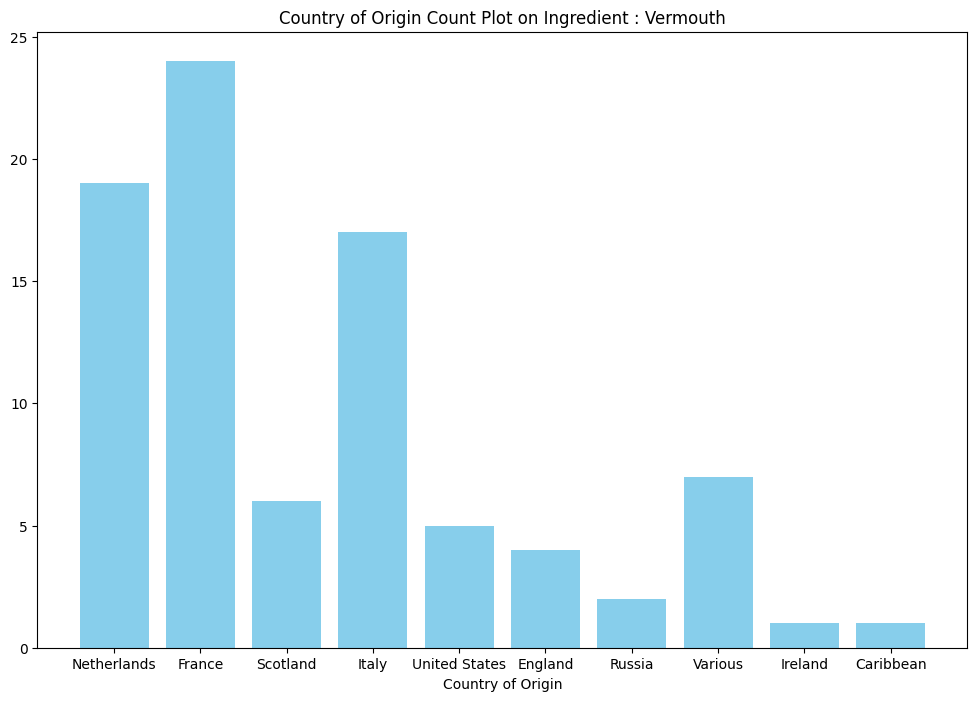

In [28]:
# plot by Country origin
fig = plt.figure(figsize=(12, 8))
# Pivot the DataFrame to prepare for grouped bar chart
if global_option == "Ingredient":
    plt.bar(df_query['strCountryofOrigin'], df_query['count'], color='skyblue')
    plt.xlabel('Country of Origin')
    plt.title(f"Country of Origin Count Plot on {global_option} : {global_user_input}")
else:
    plt.bar(df_query['strCategory'], df_query['count'], color='skyblue')
    plt.xlabel('Category')
    plt.title(f"Category Drink Count Plot on {global_option} : {global_user_input}")

plt.show()

## Step 5: Close Connection and Engine

In [29]:
# Close the conn, engine
conn.close()
engine.dispose()